In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Первинний аналіз даних
www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [2]:
data = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', parse_dates=["date"])
# test = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv', parse_dates=["date"])

data = data.set_index("date").sort_index()

In [3]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


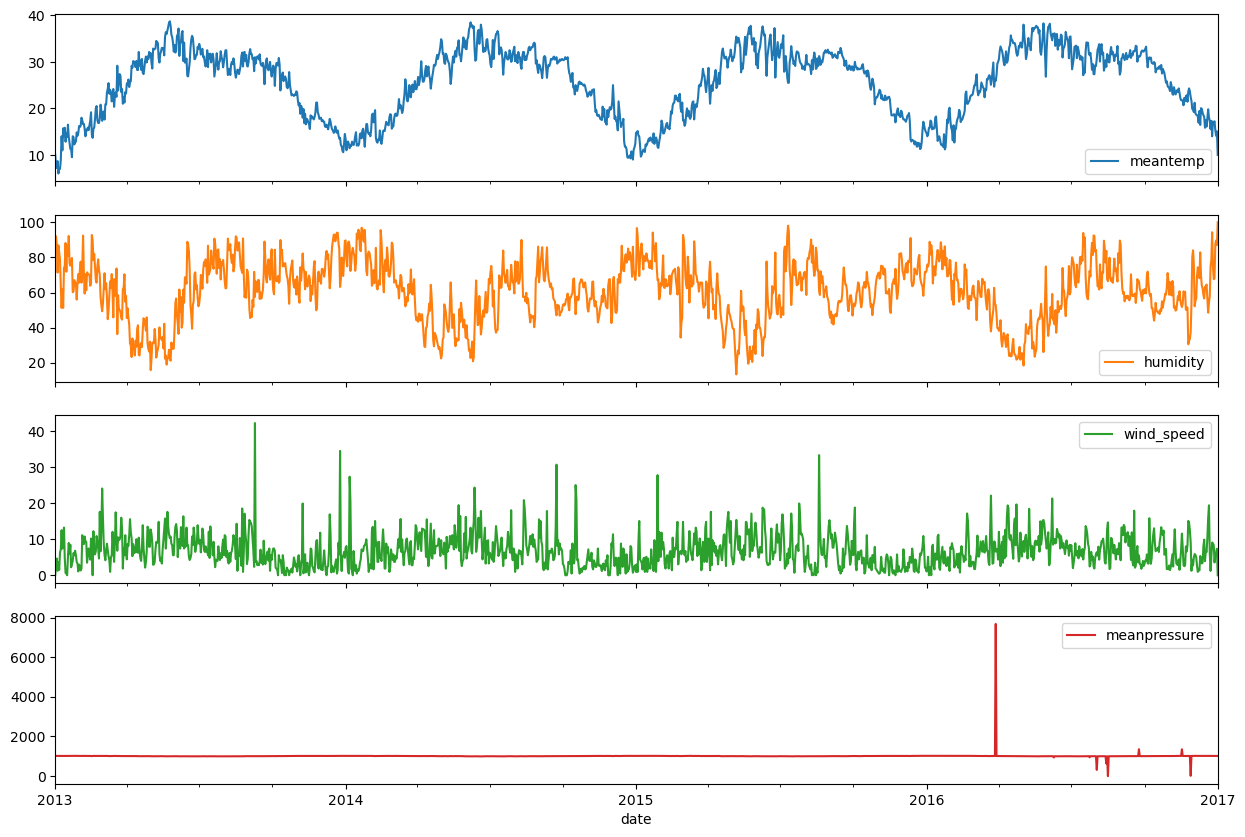

In [4]:
data.plot(subplots=True, figsize=(15, 10));

In [5]:
print(data.isna().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [6]:
np.all(data.resample('D').asfreq().index == data.index)

True

## Підготовка даних

<Axes: xlabel='date'>

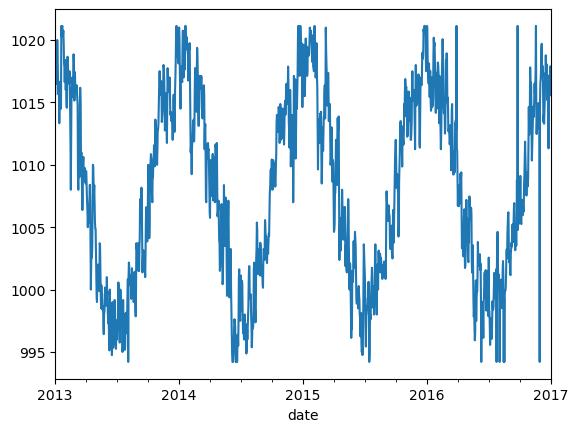

In [7]:
low = data["meanpressure"].quantile(.01)
high = data["meanpressure"].quantile(.99)

data["meanpressure"] = data["meanpressure"].clip(low, high)
data["meanpressure"].plot()

In [8]:
size = len(data)
train, test = data.iloc[:3 * size // 4], data.iloc[3 * size // 4:]

scaler = StandardScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

## Експерименти

In [9]:
def create_dataset(X, window_size=14, target_size=7):
    # Create a sliding window view of the dataset
    t, n = X.shape
    X_slide = np.zeros((t - window_size - target_size + 1, window_size + target_size, n))

    for i in range(X_slide.shape[0]):
        X_slide[i] = X[i: i + window_size + target_size]
    return X_slide[:, : window_size], X_slide[:, window_size:]

In [10]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, ConvLSTM2D


def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # store
        scores.append(mse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = s / (actual.shape[0] * actual.shape[1])
    return score, scores


def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


def forecast(model, history, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    input_x = data[-n_input:,]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat


def evaluate_forecasts_multivariate(actual, predicted):
    scores_all = list()
    score_all = list()
    for j in range(actual.shape[2]):
        scores = []
        for i in range(actual.shape[1]):
            mse = mean_squared_error(actual[:, i, j], predicted[:, i, j])
            scores.append(mse)
        # calculate overall mse
        s = 0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s += (actual[row, col, j] - predicted[row, col, j])**2
        score = s / (actual.shape[0] * actual.shape[1])

        score_all.append(score)
        scores_all.append(scores)
    return score_all, scores_all


def split_into_windows(test, n_output):
    return np.array(np.split(test[:len(test) // n_output * n_output], n_output)).transpose(1, 0, 2)    

# evaluate a single model
def evaluate_model(train, test, n_input, n_output, build_model, evaluate_forecasts=evaluate_forecasts):

    model = build_model(train, n_input, n_output)

    # walk-forward validation over each week
    history = [x for x in split_into_windows(train, n_output)]
    test = split_into_windows(test, n_output)
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])

    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores

### LSTM with Conv1D encoder

In [11]:

def build_model_conv_encoder(train, n_input, n_output):
    train_x, train_y = create_dataset(train, n_input, n_output)

    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], train_y.shape[2]))

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_output))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(loss='mse', optimizer='adam')

    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

#### Univariate LSTM with Conv1D encoder

In [12]:
train_univariate, test_univariate = train[:, [0]], test[:, [0]]
days = data.index.day_name()[:7]

Epoch 1/20
68/68 [==============================] - 2s 7ms/step - loss: 0.2496
Epoch 2/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1236
Epoch 3/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1136
Epoch 4/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1115
Epoch 5/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1037
Epoch 6/20
68/68 [==============================] - 0s 7ms/step - loss: 0.1029
Epoch 7/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1023
Epoch 8/20
68/68 [==============================] - 0s 6ms/step - loss: 0.1015
Epoch 9/20
68/68 [==============================] - 0s 6ms/step - loss: 0.0985
Epoch 10/20
68/68 [==============================] - 0s 6ms/step - loss: 0.0961
Epoch 11/20
68/68 [==============================] - 0s 6ms/step - loss: 0.0928
Epoch 12/20
68/68 [==============================] - 0s 7ms/step - loss: 0.0935
Epoch 13/20
68/68 [==============================

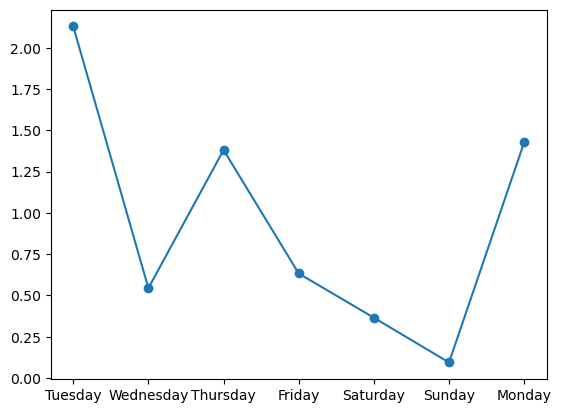

In [13]:
n_input = 14
n_output = 7

score, scores = evaluate_model(train_univariate, test_univariate, n_input, n_output, build_model_conv_encoder)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

#### Multivariate LSTM with Conv1D encoder

Epoch 1/20
68/68 [==============================] - 2s 8ms/step - loss: 0.5260
Epoch 2/20
68/68 [==============================] - 0s 7ms/step - loss: 0.3979
Epoch 3/20
68/68 [==============================] - 0s 7ms/step - loss: 0.3695
Epoch 4/20
68/68 [==============================] - 0s 6ms/step - loss: 0.3503
Epoch 5/20
68/68 [==============================] - 0s 7ms/step - loss: 0.3408
Epoch 6/20
68/68 [==============================] - 0s 6ms/step - loss: 0.3301
Epoch 7/20
68/68 [==============================] - 0s 6ms/step - loss: 0.3128
Epoch 8/20
68/68 [==============================] - 0s 6ms/step - loss: 0.3026
Epoch 9/20
68/68 [==============================] - 0s 6ms/step - loss: 0.2931
Epoch 10/20
68/68 [==============================] - 0s 6ms/step - loss: 0.2894
Epoch 11/20
68/68 [==============================] - 0s 7ms/step - loss: 0.2822
Epoch 12/20
68/68 [==============================] - 0s 6ms/step - loss: 0.2746
Epoch 13/20
68/68 [==============================

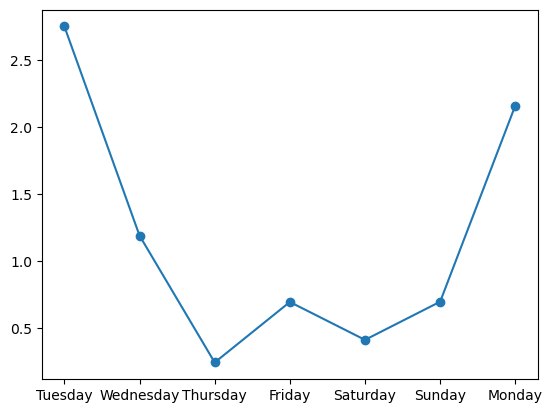

In [14]:
n_input = 14
n_output = 7

score_all, scores_all = evaluate_model(train, test, n_input, n_output, build_model_conv_encoder, evaluate_forecasts_multivariate)
for col, score, scores in zip(data.columns, score_all, scores_all):
    summarize_scores(col, score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

### ConvLSTM encoder

In [15]:
# make a forecast
def forecast_convlstm(model, history, n_steps, n_length, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    input_x = data[-n_input:, ]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, data.shape[1]))

    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat


def evaluate_model_convlstm(train, test, n_steps, n_length, n_input, n_output, build_model, evaluate_forecasts=evaluate_forecasts):
    model = build_model(train, n_steps, n_length, n_input, n_output)

    history = [x for x in split_into_windows(train, n_output)]
    test = split_into_windows(test, n_output)
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast_convlstm(model, history, n_steps, n_length, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])

    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores

#### Univariate

In [16]:
def build_model_convlstm_encoder(train, n_steps, n_length, n_input, n_output):
    train_x, train_y = create_dataset(train, n_input)
    verbose, epochs, batch_size = 1, 20, 16
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], n_features))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_output))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Epoch 1/20
68/68 [==============================] - 4s 9ms/step - loss: 0.3932
Epoch 2/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1552
Epoch 3/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1226
Epoch 4/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1123
Epoch 5/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1070
Epoch 6/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1072
Epoch 7/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1061
Epoch 8/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1026
Epoch 9/20
68/68 [==============================] - 1s 9ms/step - loss: 0.1019
Epoch 10/20
68/68 [==============================] - 1s 9ms/step - loss: 0.0985
Epoch 11/20
68/68 [==============================] - 1s 9ms/step - loss: 0.0974
Epoch 12/20
68/68 [==============================] - 1s 9ms/step - loss: 0.0980
Epoch 13/20
68/68 [==============================

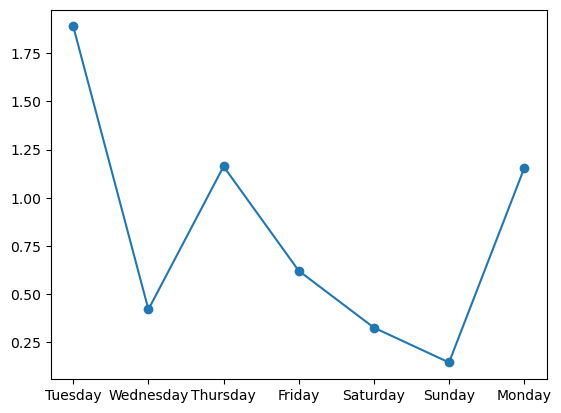

In [17]:
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps

score, scores = evaluate_model_convlstm(
    train_univariate,
    test_univariate,
    n_steps,
    n_length,
    n_input,
    n_output,
    build_model_convlstm_encoder
)
summarize_scores('lstm', score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

#### Multivariate

Epoch 1/20
68/68 [==============================] - 4s 9ms/step - loss: 0.5850
Epoch 2/20
68/68 [==============================] - 1s 9ms/step - loss: 0.4165
Epoch 3/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3846
Epoch 4/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3725
Epoch 5/20
68/68 [==============================] - 1s 10ms/step - loss: 0.3592
Epoch 6/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3511
Epoch 7/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3437
Epoch 8/20
68/68 [==============================] - 1s 10ms/step - loss: 0.3424
Epoch 9/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3325
Epoch 10/20
68/68 [==============================] - 1s 10ms/step - loss: 0.3244
Epoch 11/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3176
Epoch 12/20
68/68 [==============================] - 1s 9ms/step - loss: 0.3151
Epoch 13/20
68/68 [===========================

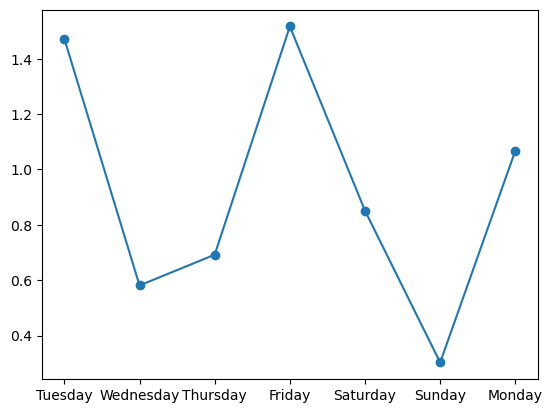

In [18]:
n_steps, n_length = 2, 7
n_input = n_length * n_steps

score_all, scores_all = evaluate_model_convlstm(
    train,
    test,
    n_steps,
    n_length,
    n_input,
    n_output,
    build_model_convlstm_encoder,
    evaluate_forecasts_multivariate
)
for col, score, scores in zip(data.columns, score_all, scores_all):
    summarize_scores(col, score, scores)

plt.plot(days, scores, marker='o', label='lstm')
plt.show()

## Висновки

Показники MSE моделей:
- Univariative lstm with Conv1D encoder: [0.939] 2.1, 0.5, 1.4, 0.6, 0.4, 0.1, 1.4
- Multivariative lstm with Conv1D encoder: [1.016] 3.1, 0.3, 0.6, 0.4, 0.1, 0.3, 2.3
- Univariative lstm with ConvLSTM encoder: [0.817] 1.9, 0.4, 1.2, 0.6, 0.3, 0.1, 1.2
- Multivariative lstm with ConvLSTM encoder: [0.927] 2.9, 0.3, 0.9, 0.5, 0.2, 0.2, 1.5

З аналізу показників MSE можна зробити наступні висновки:

У моделі "Univariative LSTM with Conv1D encoder" середнє значення MSE становить 0.939. Це значення гірше, ніж у попередньої моделі LSTM (0.805), що використовувала одномірні дані. Таким чином, дана модель на основі багатовимірних вхідних даних не є стабільнішою порівняно з одномірною моделлю.

Модель "Multivariative LSTM with Conv1D encoder" також має високе середнє значення MSE, яке становить 1.016. Це далеко перевищує значення MSE моделі LSTM з багатовимірними вхідними даними з попередньої роботи (0.851). Таким чином, ця модель також не є стабільнішою порівняно з попередньою моделлю.

Моделі "Univariative LSTM with ConvLSTM encoder" та "Multivariative LSTM with ConvLSTM encoder" мають середні значення MSE 0.817 та 0.927 відповідно. Ці значення є трохи кращими, ніж у попередніх моделях, але все ще не досягають рівня стабільності, який був продемонстрований моделлю LSTM з багатовимірними вхідними даними в попередній роботі (0.851).

Отже, можна зробити висновок, що ні одна з досліджених моделей на основі багатовимірних вхідних даних не є більш стабільною порівняно з моделлю LSTM, що використовує одномірні дані.

Це може бути пов'язане з тим, що моделі виявились занадто ємними для наданого датасету, що могло спричинити перенавчання моделей.